# 1D Fast Accurate Fourier Transform
## Version that calls cuFFT functions
### Complex to Complex
### Double precision

In [1]:
import numpy as np
import ctypes
from ctypes import *

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit

import cufft_wrapper as cufft
import faft_1d as faft

import time

In [2]:
%matplotlib inline    

## Loading FFT routines

## Initializing Grid

 The position space is $x$ 

The Fourier space is  $\theta$

In [3]:
gridDIM_x   = 128

# Phase space window 
x_amplitude   = 12.

# Ambiguity space window 
theta_x_amplitude  = 10.

# Create and initialize FAFT plan
FAFT_Plan = faft.Plan_FAFT_1D_Z2Z(  x_amplitude, theta_x_amplitude, gridDIM_x )

In [4]:
def Gaussian(x,mu,sigma):
    return np.exp( - (x-mu)**2/sigma**2/2. )/(sigma*np.sqrt( 2*np.pi  ))

def fftGaussian(p,mu,sigma):
    return np.exp(-1j*mu*p)*np.exp( - p**2*sigma**2/2. )

def norm_CPU(W):
    return np.sum(W).real*dx

## Initializing the state

In [5]:
# Gaussian parameters in the Phase space -------------------------

x_mu = 1.5
x_sigma = 1.

dx = 2*x_amplitude  /float(gridDIM_x)  
x = np.linspace( -x_amplitude,   x_amplitude  -dx,    gridDIM_x  ) 
f = Gaussian( x , x_mu, x_sigma )

f = f + 0j

norm = norm_CPU(f)
f   /= norm

print " Amplitude x = ",  x_amplitude
print '        '

print 'mu_x = ', x_mu

print '   '

print 'n     = ', x.size
print 'dx    = ', dx
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '


print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '    min = ', np.min(f.real)

print '  '
print 'Normalization = ', np.sum( f ).real*dx

 Amplitude x =  12.0
        
mu_x =  1.5
   
n     =  128
dx    =  0.1875
           standard fft dp =  0.261799387799      
    
    
The Gaussian extends to the numerical error in single precision:
    min =  1.06126881392e-40
  
Normalization =  1.0


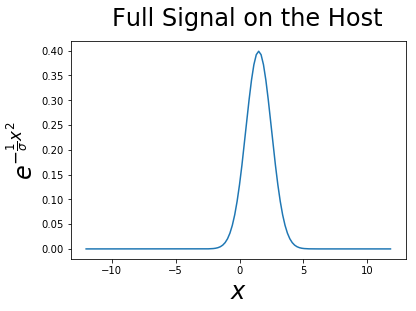

In [6]:
plt.plot(x, f.real,'-')

axis_font = {'size':'24'}
plt.text( -10, 0.45, 'Full Signal on the Host' , **axis_font)
plt.ylabel('$e^{-\\frac{1}{\\sigma }x^2}$',**axis_font)
plt.xlabel('$x$',**axis_font)

#plt.ylim(0,1)

## $W$ TRANSFORM

## Forward Transform

In [7]:
# Allocate gpu memory and copy data

y_gpu    = gpuarray.zeros( gridDIM_x*2 , dtype=np.complex128 )

y_gpu[0:gridDIM_x] = f[:]


In [8]:
FAFT_Plan.FAFT( y_gpu )

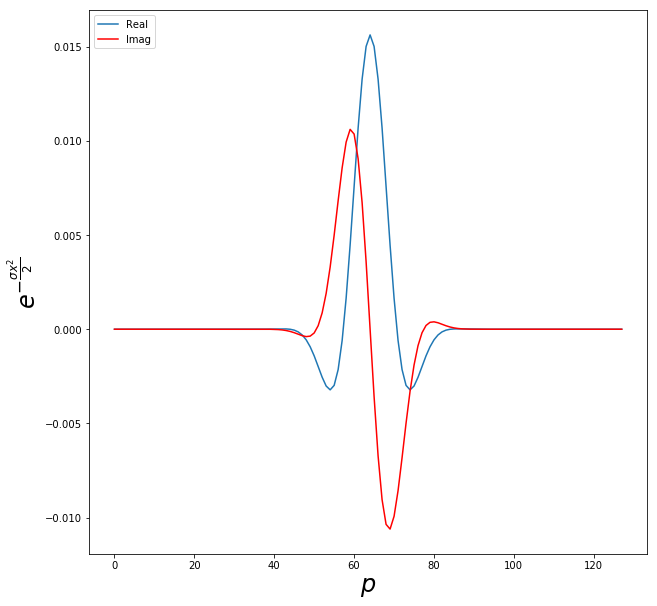

In [9]:
plt.figure(figsize=(10,10))

plt.plot(  y_gpu[0:gridDIM_x].get().real,  '-', label='Real', markersize=1 )
plt.plot(  y_gpu[0:gridDIM_x].get().imag,  'r-', label='Imag', markersize=1 )

plt.legend(loc='upper left')

#plt.ylim(-0.3 , 1.1)

plt.ylabel('$e^{- \\frac{\\sigma x^2}{2} }$',**axis_font)
plt.xlabel('$p$',**axis_font)

### Inverse Transform

In [10]:
FAFT_Plan.iFAFT( y_gpu )

In [11]:
# Normalize data

norm = FAFT_Plan.norm_GPU( y_gpu )

y_gpu[:] /= norm

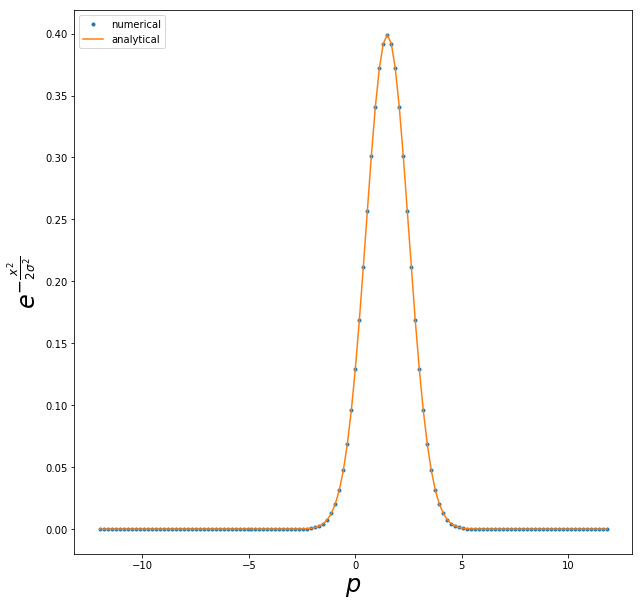

In [12]:
plt.figure(figsize=(10,10))

plt.plot( x,  y_gpu[0:gridDIM_x].get().real, '.', label='numerical')

plt.plot( x, Gaussian(x, x_mu, x_sigma) , '-',label = 'analytical')

plt.legend(loc='upper left')

#plt.ylim(0,0.5)

plt.ylabel('$e^{- \\frac{x^2}{2 \\sigma^2 } }$',**axis_font)
plt.xlabel('$p$',**axis_font)

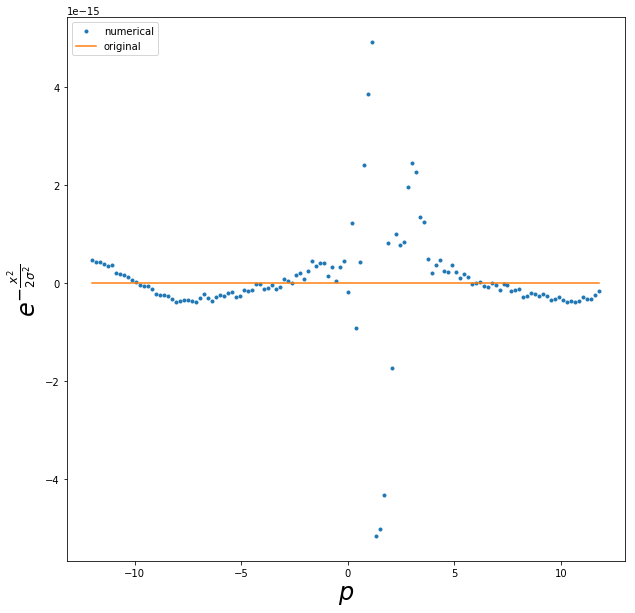

In [13]:
plt.figure(figsize=(10,10))

plt.plot( x,  y_gpu[0:gridDIM_x].get().imag, '.', label='numerical')

plt.plot( x,  f.imag, '-', label = 'original')

plt.legend(loc='upper left')

#plt.ylim(0,0.5)

plt.ylabel('$e^{- \\frac{x^2}{2 \\sigma^2 } }$',**axis_font)
plt.xlabel('$p$',**axis_font)

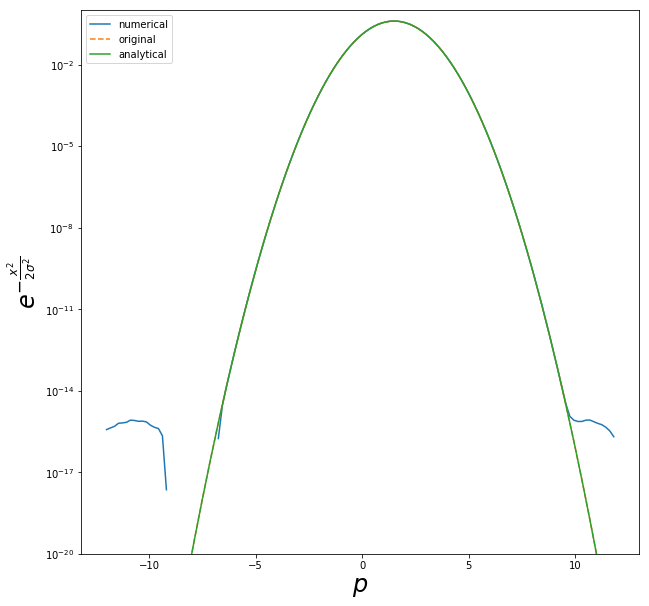

In [14]:
# LOG PLOT 

plt.figure(figsize=(10,10))

plt.semilogy( x,  y_gpu[0:gridDIM_x].get().real  , '-', label='numerical')

plt.semilogy( x, f.real  , '--', label='original')

plt.semilogy( x, Gaussian(x, x_mu, x_sigma) , label = 'analytical')

plt.legend(loc='upper left')

plt.ylim(1e-20,1)

plt.ylabel('$e^{- \\frac{x^2}{2 \\sigma^2 } }$',**axis_font)
plt.xlabel('$p$',**axis_font)